**Кулешов Иван AML-14**

# Временные ряды, задание №3
## по теме "Модели ARIMA"

- Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.
- Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [ ]:
# Делаю домашку в Google Colab
!pip install arch

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm
from arch import arch_model
from sklearn.linear_model import LinearRegression

In [ ]:
# Тест на стационарность с выводом параметров
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
# отрисовка графиков временного ряда, автокорреляции, графика нормальности
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

# Решение

Загрузим наш временной ряд:

In [ ]:
#ser = 'monthly-sales-of-company-x-jan-6.csv'
ser ='international-airline-passengers.csv'

df = pd.read_csv(ser, sep=',', index_col=['Month'], parse_dates=['Month'], dayfirst=True)
series = df.Count

Выводим:

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


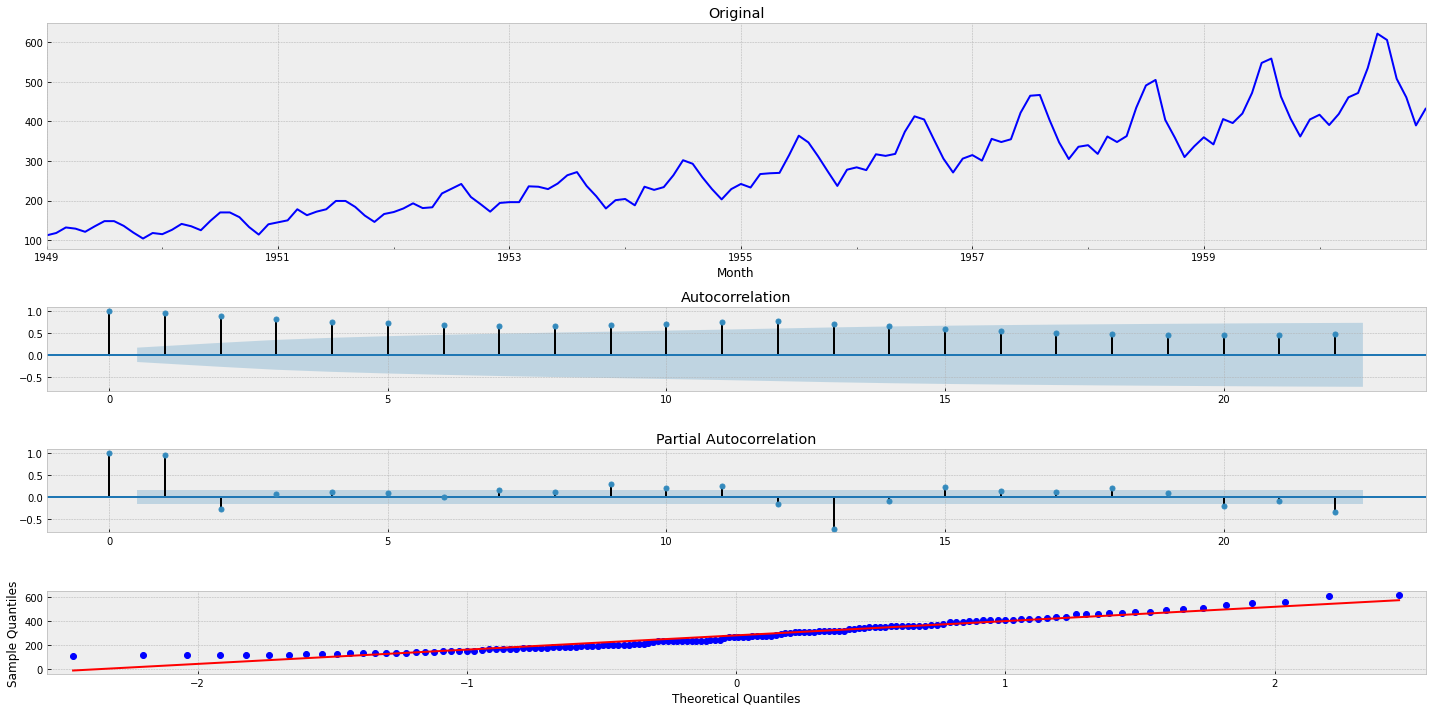

In [ ]:
tsplot(series)

По тесту Дики-Фуллера видно, что ряд нестационарный.

Построим модель ARIMA по следующей схеме:
- выполним преобразование Бокса-Кокса
- разделим преобразованную выборку на обучающую и тестовую
- на обучающей прогоним обучение модели ARIMA
- затем проанализируем полученные остатки
- если они удовлетворяют критериям отсутствия остаточной информации, то выведем график прогноза на основе модели ARIMA, используя обратное преобразование Бокса-Кокса

In [ ]:
# Выполняет обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
  if lmbda == 0:
    return(np.exp(y))
  else:
    return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
# Выполняем преобразование Бокса-Кокса и запоминаем параметр преобразования для обратного
df['Count_box'], lmbda = boxcox(df['Count'])

#### Модель ARIMA

In [ ]:
# Функция, обучающая модель ARIMA на произвольном ряде series
def get_best_model(series):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in tqdm(range(5)):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = sm.tsa.statespace.SARIMAX(series, order=(i,d,j),
                                                        seasonal_order=(0, 1, 0, 12)).fit()
                   # tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(
                   #     method='mle', trend='nc'
                   # )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

Для обучающей выборки возьмем 66% ряда:

In [ ]:
ts_test = round(len(series) * 0.66)
ts_test

95

Разбиваем на обучающую и тестовую преобразованные данные:

In [ ]:
train, test = df.Count_box[:ts_test], df.Count_box[ts_test:]

Обучаем модель ARIMA на части временного ряда - train

In [ ]:
best_aic, best_order, best_mdl = get_best_model(train)


aic: -140.27358 | order: (3, 1, 2)


Выводим график остатков:

Results of Dickey-Fuller Test:
Test Statistic                -20.572624
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


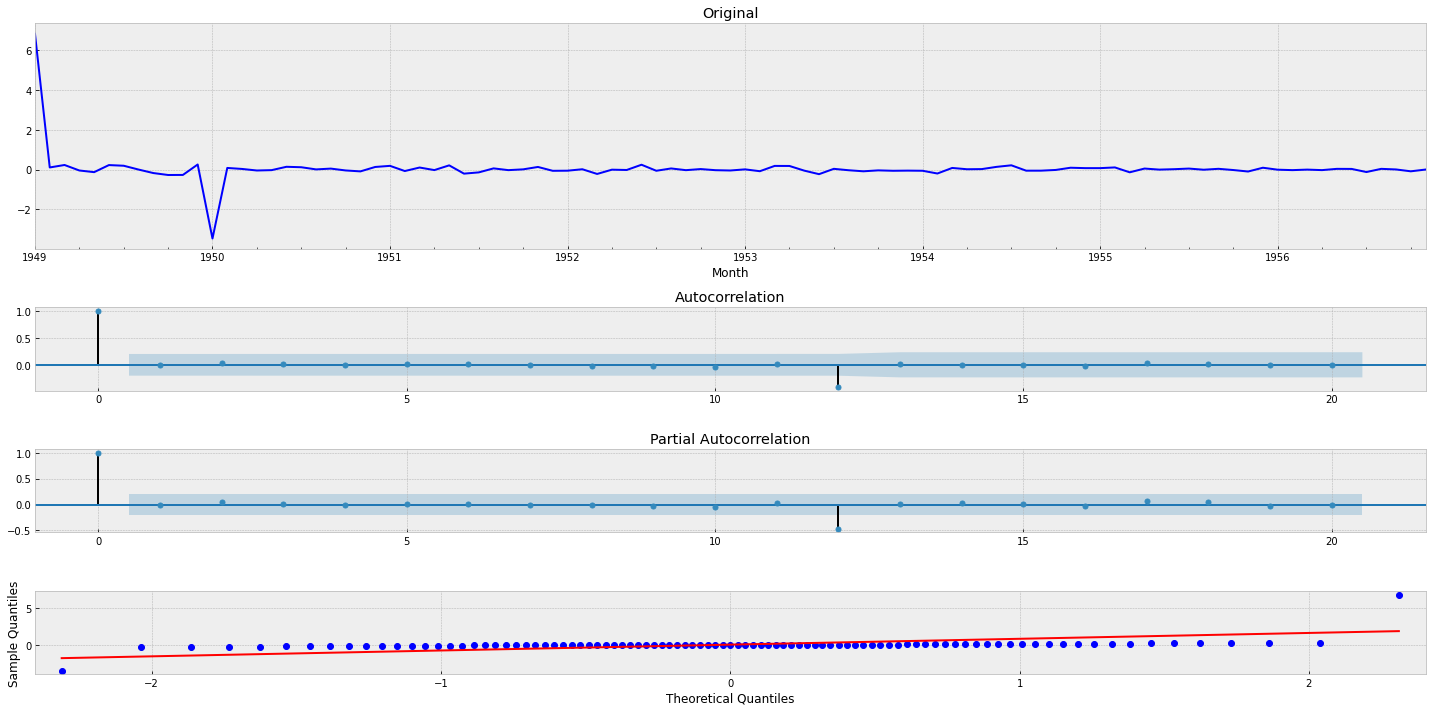

In [ ]:
tsplot(best_mdl.resid)

Тест Дики-Фуллера свидетельствует что полученный ряд стационарный

Проверим, что остатки нормально распределены:

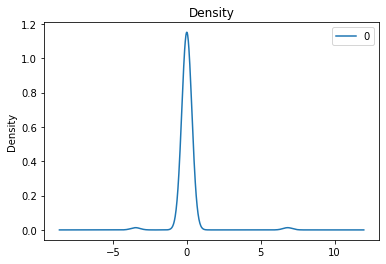

In [ ]:
residuals = pd.DataFrame(best_mdl.resid)
residuals.plot(kind='kde', title='Density')
plt.show()

Теперь выведем график, содержащий исходный ряд и прогноз:

In [ ]:
# Обратное преобразование для прогноза
df['Forecast'] = invboxcox(best_mdl.predict(start=1, end = len(series)),
                           lmbda)

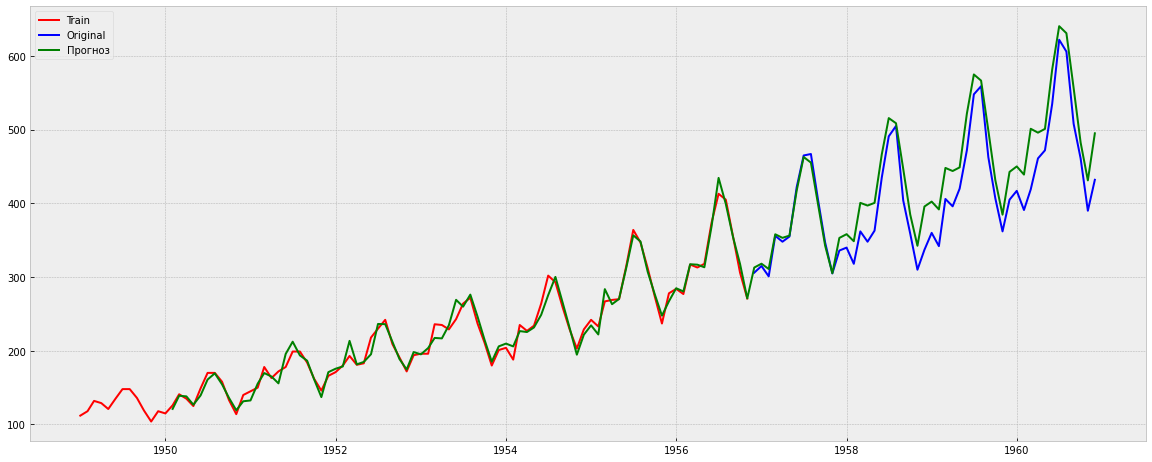

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plt.plot(df.Count[:ts_test], color='red', label='Train')
    plt.plot(df.Count[ts_test:], color='blue', label='Original')
    plt.plot(df.Forecast[13:], color='green', label='Прогноз')
    plt.legend()
    plt.show()

**Вывод:**

Для первых прогнозных сезонных "витков" предсказанные значения довольно близки к исходным, затем наблюдается все сильнейшее расхождение.

#### Модель GARCH

В качестве отправной точки для GARCH используем параметры, полученные с помощью модели ARIMA

In [360]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_,  mean = "constant", dist = "Normal")
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              Count_box   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -78.7989
Distribution:                  Normal   AIC:                           173.598
Method:            Maximum Likelihood   BIC:                           194.029
                                        No. Observations:                   95
Date:                Fri, Jun 18 2021   Df Residuals:                       94
Time:                        09:33:11   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             8.0457  9.591e-02     83.885      0.000 [  7.858,  8.23

Выводим получившийся график волатильности:

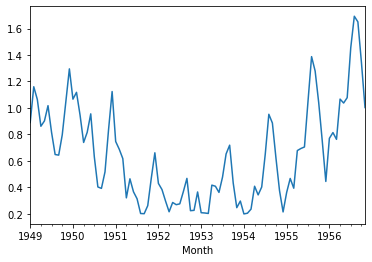

In [370]:
res.conditional_volatility.plot()

Спрогнозируем дисперсию ряда:

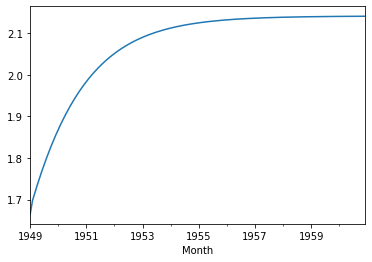

In [371]:
df['Forecast1'] = invboxcox(res.forecast(horizon=len(df), reindex=True).variance.values[-1, :], lmbda)
df['Forecast1'].plot()

#### Попробуем классический ML

In [372]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['reg']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['reg'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["reg"], axis=1)
    y_train = data.loc[:test_index]["reg"]
    X_test = data.loc[test_index:].drop(["reg"], axis=1)
    y_test = data.loc[test_index:]["reg"]
    
    return X_train, X_test, y_train, y_test

In [379]:
X_train, X_test, y_train, y_test = prepareData(df.Count, lag_start=1, lag_end=20, test_size=0.33)

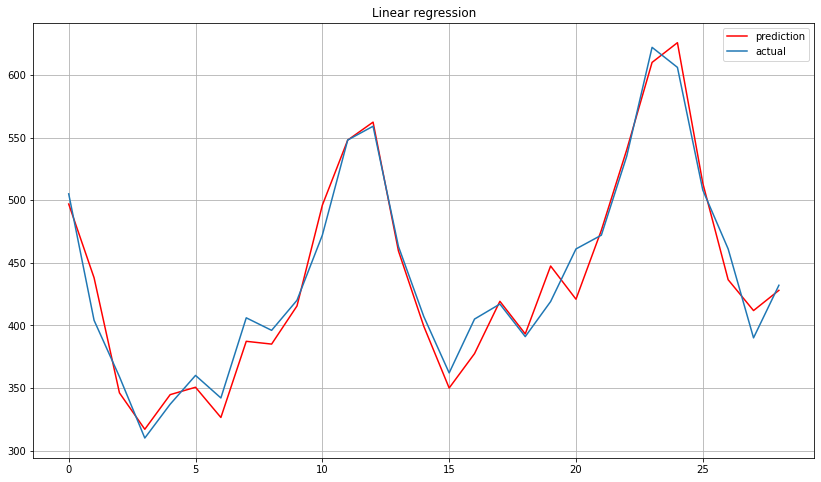

In [380]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

**Вывод:**

Обычная линейная регрессия, возможно, показала лучший результат